In [55]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re


#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelBinarizer

In [6]:
#read imdb data
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Removing the noisy text
def cleanup_text(text):
    text = to_unicode(text)
    text = strip_html(text)
    text = re.sub(r"http\S+", "", text)
    text = text.encode('ascii', 'ignore')
    text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text

<>:17: SyntaxWarning: invalid escape sequence '\['
<>:17: SyntaxWarning: invalid escape sequence '\['
C:\Users\John\AppData\Local\Temp\ipykernel_19208\374581140.py:17: SyntaxWarning: invalid escape sequence '\['
  return re.sub('\[[^]]*\]', '', text)


In [9]:
#Apply cleanup function on review column

imdb_df['review']=imdb_df['review'].apply(cleanup_text)
imdb_df['review'].head()

C:\Users\John\AppData\Local\Temp\ipykernel_19208\374581140.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

<h1> Data Visualizations </h1>

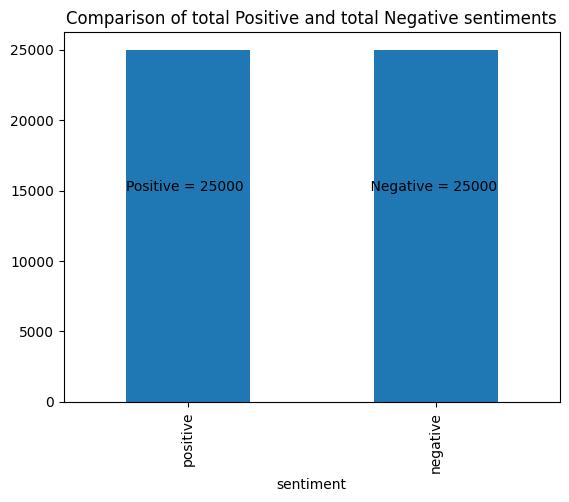

In [33]:
#visualize the sentiments of the original data
imdb_df.sentiment.value_counts().plot(kind = 'bar')
plt.annotate('Positive = '+ str(sum(imdb_df['sentiment'] == 'positive'))+'                             Negative = '+str(sum(imdb_df['sentiment'] == 'negative')), xy=(0,0), xytext=(-0.25,15000))
plt.title('Comparison of total Positive and total Negative sentiments')
plt.show()

<h1>Model Creation</h1>

<h3> Data preparation </h3>

In [35]:
#binarize the positive and negative sentiments: Positive = 1, Negative = 0
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(imdb_df['sentiment'])
print(sentiment_data.shape)
sentiment_data

(50000, 1)


array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [36]:
#store the reviews
norm_reviews = imdb_df.review
norm_reviews

0        one of the other reviewers has mentioned that ...
1        a wonderful little production the filming tech...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [38]:
#create a matrix of words in the reviews
cv = CountVectorizer()
#fit the model on the dataset
cv_fit =cv.fit(norm_reviews)


<h3> Bag of Words Model </h3>

In [39]:
#split reviews into train and test data and fit the model
#train
norm_train_reviews = imdb_df.review[:45000]
norm_train_cv_reviews = cv_fit.transform(norm_train_reviews)

#test
norm_test_reviews = imdb_df.review[45000:]
norm_test_cv_reviews = cv_fit.transform(norm_test_reviews)


In [40]:
#split the sentiment data into train and test
#train
train_sentiments=sentiment_data[:45000]

#test
test_sentiments=sentiment_data[45000:]

In [41]:
#use logistic regression to fit reviews to sentiment
lr = LogisticRegression(penalty='l2', max_iter=500, C=1 , random_state=42)

lr_bagofwords = lr.fit(norm_train_cv_reviews,train_sentiments)
lr_bagofwords

c:\Users\John\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\John\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, max_iter=500, random_state=42)

In [44]:
#predict using logistic regression - bag of words
lr_bagofwords_predict = lr.predict(norm_test_cv_reviews)
print(lr_bagofwords_predict)
len(lr_bagofwords_predict)

[1 1 0 ... 0 1 0]


5000

<h3> TF-IDF Model with Logistic Regression</h3>

In [46]:
#create TFIDF vectorizer and fit it onto the review data
tv = TfidfVectorizer()

tv_fit = tv.fit(norm_reviews)

In [47]:
#split reviews into train and test data and fit the model
#train
norm_train_reviews = imdb_df.review[:45000]
norm_train_tv_reviews = tv_fit.transform(norm_train_reviews)

#test
norm_test_reviews = imdb_df.review[45000:]
norm_test_tv_reviews = tv_fit.transform(norm_test_reviews)


In [48]:
#use logistic regression to fit reviews to sentiment
lr = LogisticRegression(penalty='l2', max_iter=500, C=1 , random_state=42)

lr_tfidf = lr.fit(norm_train_tv_reviews,train_sentiments)
lr_tfidf

c:\Users\John\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)

In [49]:
#predict using logistic regression - bag of words
lr_tfidf_predict = lr.predict(norm_test_tv_reviews)
print(lr_tfidf_predict)
len(lr_tfidf_predict)

[1 1 0 ... 1 0 0]


5000

<h3> Random Forest Classifier Model</h3>

In [60]:
#create random forest classifier and fit it onto the review data
rf = RandomForestClassifier(n_estimators=100, random_state=69)

rf_fit = rf.fit(norm_train_tv_reviews,sentiment_data[0:45000])

c:\Users\John\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [61]:
rf_predict = rf.predict(norm_test_tv_reviews)
rf_predict

array([1, 1, 0, ..., 1, 1, 0])

<h3> Accuracy Scores for Each Model</h3>

In [64]:
#accuracy score for Bag of Words model
lr_bagofwords_score = accuracy_score(test_sentiments,lr_bagofwords_predict)
print(f'LR Bag of Words Accuracy Score: {lr_bagofwords_score}')

#accuracy score for tfidf model
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print(f'LR tfidf Accuracy Score: {lr_tfidf_score}')

#accuracy score for RF model
rf_score=accuracy_score(test_sentiments,rf_predict)
print(f'LR tfidf Accuracy Score: {rf_score}')

LR Bag of Words Accuracy Score: 0.8932
LR tfidf Accuracy Score: 0.896
LR tfidf Accuracy Score: 0.8408


<h3> Classification Reports for Each Model</h3>

In [53]:
#classification report for bag of words linear regression
lr_bagofwords_report = classification_report(test_sentiments, lr_bagofwords_predict,target_names=['Positive','Negative'])
print("Classification Report for Bag of Words - Linear Regression")
print(lr_bagofwords_report)

Classification Report for Bag of Words - Linear Regression
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      2530
    Negative       0.89      0.89      0.89      2470

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [54]:
#classification report for tfidf linear regression
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict,target_names=['Positive','Negative'])
print("Classification Report for TFIDF - Linear Regression")
print(lr_tfidf_report)

Classification Report for TFIDF - Linear Regression
              precision    recall  f1-score   support

    Positive       0.90      0.90      0.90      2530
    Negative       0.89      0.90      0.89      2470

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [63]:
#classification report for random forest model
rf_report = classification_report(test_sentiments, rf_predict,target_names=['Positive','Negative'])
print("Classification Report for RF Model")
print(rf_report)

Classification Report for RF Model
              precision    recall  f1-score   support

    Positive       0.84      0.85      0.84      2530
    Negative       0.84      0.83      0.84      2470

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

